In [1]:
import pandas as pd
import openai
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm

In [2]:
openai.api_key = "api_key"

In [3]:
df = pd.read_csv("publications.csv")
df.head(3)

,title,type,year,description,authors
0,The Problem Of Reputation Reliability In Onlin...,PREPRINT,2023,This paper explains how the problem of reputat...,"['Ишмухаметова Э. И.', 'Сандомирская М. С.']"
1,Casualties of border changes: Evidence from ni...,PREPRINT,2022,We investigate the economic effects of the Rus...,"['Бехренс К.', 'Кузнецова М. Ю.']"
2,Destabilizing effects of market size in the dy...,ARTICLE,2022,In existing models of endogenous innovation cy...,"['Ущев Ф. А.', 'Matsuyama K.']"


<h4>Аналитика частоты публикаций</h4>

In [4]:
values = df.groupby("year")["year"].count().tolist()

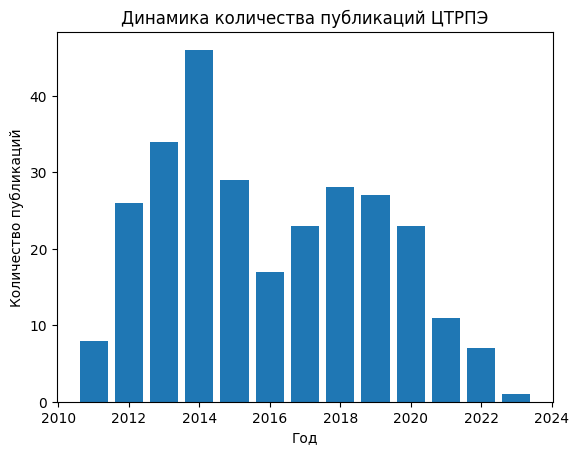

In [5]:
plt.bar(range(2011, 2024), values)
plt.xlabel("Год")
plt.ylabel("Количество публикаций")
plt.title("Динамика количества публикаций ЦТРПЭ")

plt.savefig("dynamic.png", dpi=300)

In [171]:
df.authors = df.authors.apply(lambda x: eval(x))

In [501]:
df_authors = df.explode(["authors"])

In [504]:
df_top_authors = df_authors.groupby(
    "authors"
)["title"].count().to_frame().sort_values(
    "title", ascending=False
).rename(columns={
    "title": "Количество публикаций"
})

df_top_authors

,Количество публикаций
authors,
Ущев Ф. А.,33
Тисс Ж.,31
Кичко С. И.,29
Коковин С. Г.,25
Бехренс К.,24
...,...
Shepotylo O.,1
Shimomura K.,1
Sudekum J.,1


In [505]:
top_authors = df_top_authors.index.tolist()

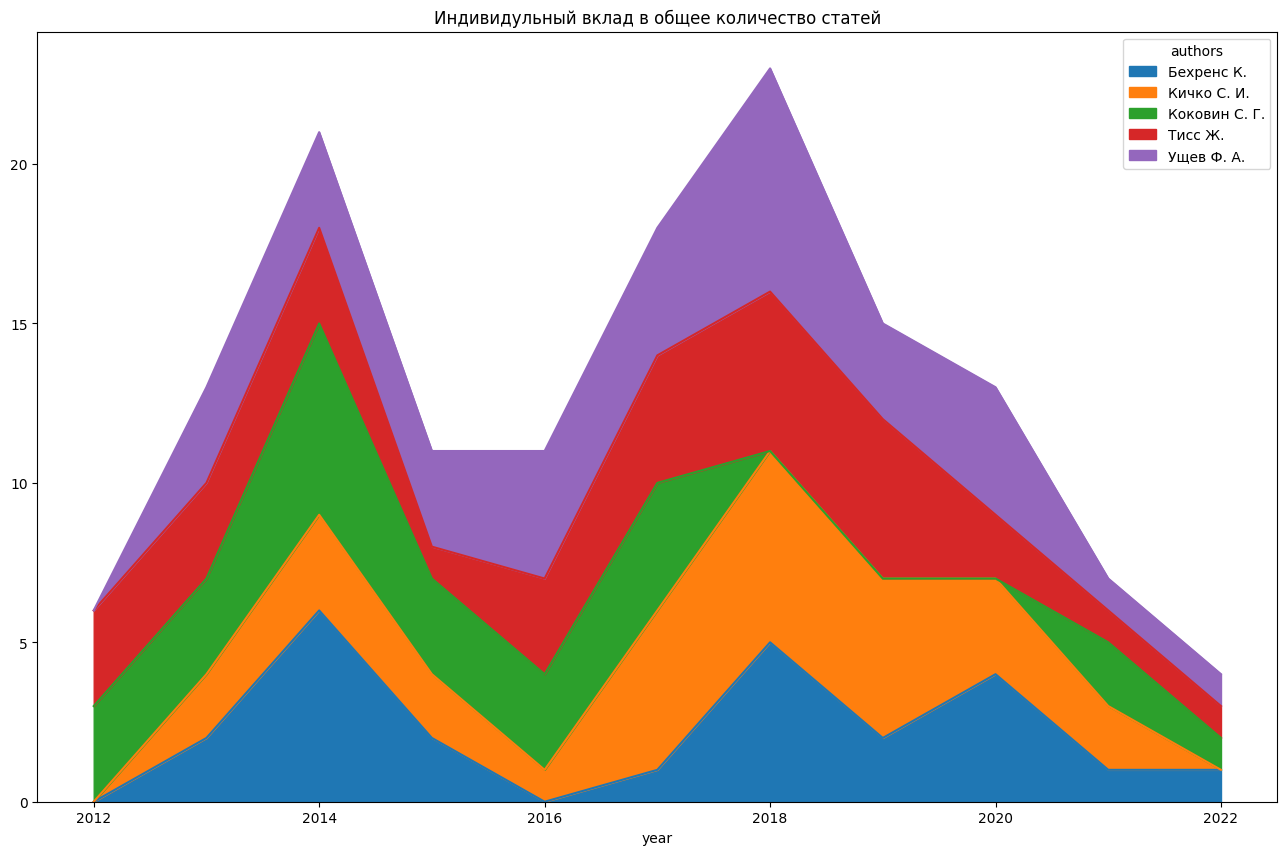

In [506]:
df_stacked = df_authors[
    df_authors.authors.isin(top_authors[:5])
].groupby(["year", "authors"]).size().unstack().plot(kind='area', stacked=True, figsize=(16,10))


plt.title("Индивидульный вклад в общее количество статей")
plt.savefig("publications_ratio", dpi=300)

<h4>Карта - автор - топик</h4>

In [507]:
X_auth = []

for author in top_authors:
    
    X_auth.append(
        df_authors[
            df_authors.authors == author
        ]["description_embeddings"].to_numpy().mean(axis=0)
    )
    
X_auth = np.array(X_auth)

In [508]:
# do PCA plot for average author papers embeddings
pca_auth = PCA(n_components=20).fit(X_auth)
PCA_auth = pca_auth.transform(X_auth)

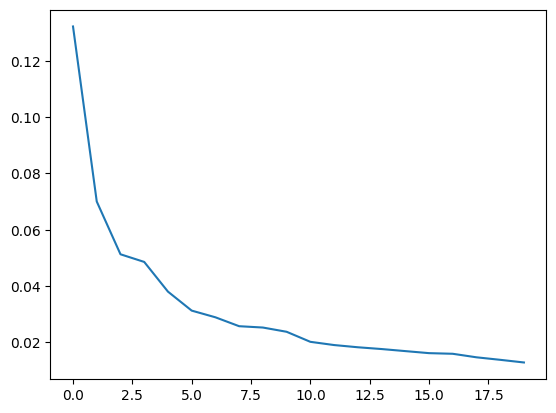

In [509]:
plt.plot(pca_auth.explained_variance_ratio_)

In [510]:
df_num_groups = df_authors[df_authors.authors == "Коковин С. Г."].kmeans_group.value_counts()
df_num_groups.index[df_num_groups.argmax()]

2

In [511]:
author_liked_topic = {}

for author in top_authors:
    df_num_groups = df_authors[
        df_authors.authors == author
    ].kmeans_group.value_counts()
    most_liked_topic = df_num_groups.index[df_num_groups.argmax()]
    author_liked_topic[author] = most_liked_topic

In [561]:
keywords_category = []

for el in df_authors[df_authors.kmeans_group == 0].keywords.tolist():
    keywords_category.extend(el)

In [563]:
# np.unique(np.array(keywords_category))

In [547]:
colors = [
    np.round(author_liked_topic[author])
    for author in top_authors
]

labels = [
    "Game Theory", 
    "Spatial Economics",
    "Microeconomics", 
    "Business and Economics", 
    "Economics in other fields"
]

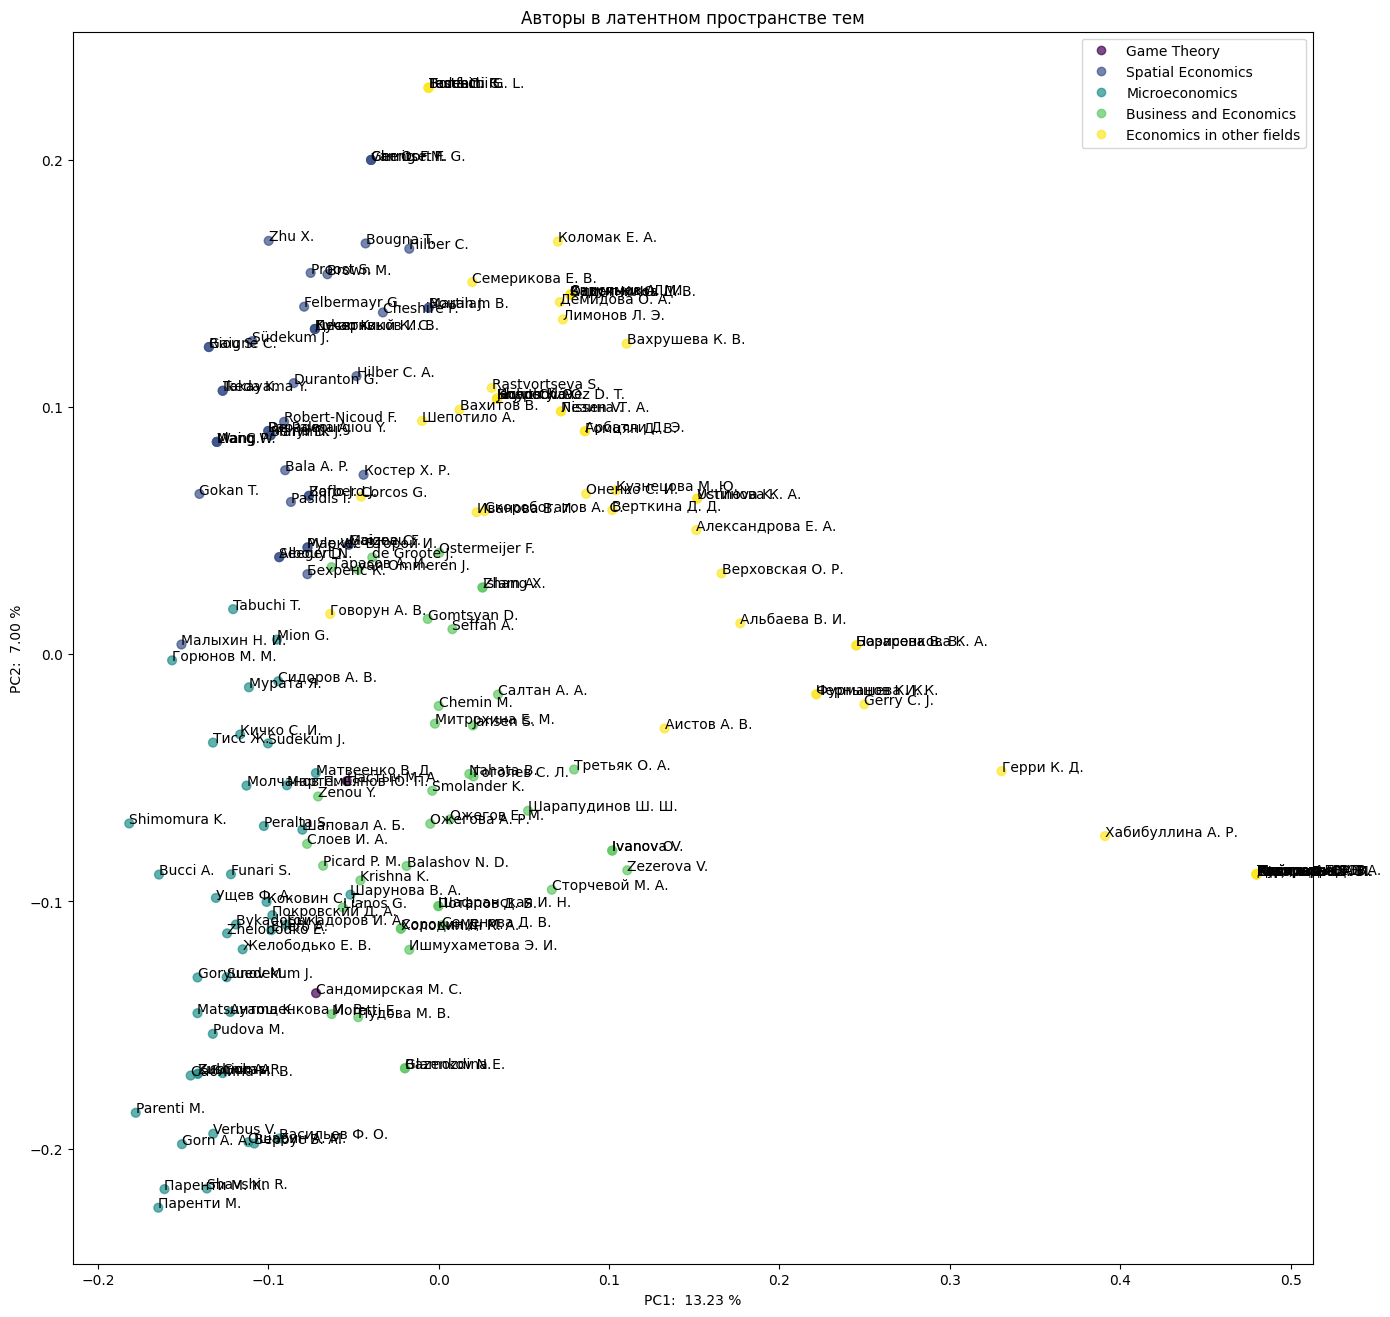

In [554]:
plt.figure(figsize=(16, 16))

scatter = plt.scatter(PCA_auth[:, 0], PCA_auth[:, 1], s=40, alpha=0.7, c=colors)
plt.xlabel("PC1:  {:.2f} %".format(pca_auth.explained_variance_ratio_[0]*100))
plt.ylabel("PC2:  {:.2f} %".format(pca_auth.explained_variance_ratio_[1]*100))

for i, author in enumerate(top_authors):
    plt.annotate(author, (PCA_auth[i, 0], PCA_auth[i, 1]), fontsize=10)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)

plt.title("Авторы в латентном пространстве тем")

plt.savefig("authors_by_group.png", dpi=300, bbox_inches="tight")

plt.show()

In [568]:
df_pubs_group = df_authors.groupby("kmeans_group")["authors"].count().to_frame()
df_pubs_group.index = labels
df_pubs_group.rename({"authors": ""})

,authors
Game Theory,20
Spatial Economics,112
Microeconomics,200
Business and Economics,106
Economics in other fields,107


In [7]:
df = df[df.description.notna()]
df = df.reset_index(drop=True)

<h3>Get Keywords from abstract</h3>

In [8]:
key_words = []

for desc in tqdm(df.description):
    resp = openai.Completion.create(
        model="text-davinci-003",
        prompt=f"""Extract up to 5 key words describing the aim of the paper 
        from this description: \n\n <{desc}> \n\n Output result separated by semicolumns""",
        max_tokens=1000
    ) 
    
    data = [
        el.strip()
        for el in re.sub("[^\w\s\;\-]", "", resp["choices"][0]["text"]).split(";")
    ]

    key_words.append(data)

100%|█████████████████████████████████████████| 224/224 [06:28<00:00,  1.74s/it]


In [9]:
df["keywords"] = key_words

In [10]:
df.keywords = df.keywords.apply(lambda x: [el for el in x if el])

In [11]:
key_embeddings = []

for key_list in tqdm(df.keywords):
    resp = openai.Embedding.create(
        input=key_list,
        model="text-embedding-ada-002"
    ) 
    key_embeddings.append([el["embedding"] for el in resp["data"]])

100%|█████████████████████████████████████████| 224/224 [01:54<00:00,  1.95it/s]


In [122]:
resp = openai.Embedding.create(
    input=df.description.tolist(),
    model="text-embedding-ada-002"
)

In [123]:
description_embeddings = [np.array(el["embedding"]) for el in resp["data"]]

In [124]:
df["description_embeddings"] = description_embeddings

In [96]:
df["key_embeddings"] = key_embeddings

In [97]:
def get_avg_embedding(embs):
    return np.mean([np.array(emb) for emb in embs], axis=0)

In [98]:
# get average phrase embeddings
df["avg_embeddings"] = df["key_embeddings"].apply(get_avg_embedding)

In [99]:
df.to_csv("authors_embedded.csv", index=False)

<h3>Clustering</h3>

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

In [483]:
X = np.array(df["description_embeddings"].tolist())

<h3>HClustering</h3>

In [484]:
link = linkage(X, 'ward', 'euclidean')
dist_clusters = link[:, 2] # -> distance between clusters

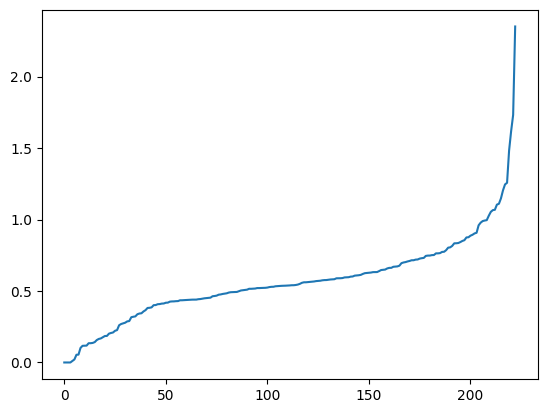

In [485]:
plt.plot(dist_clusters)
plt.show()

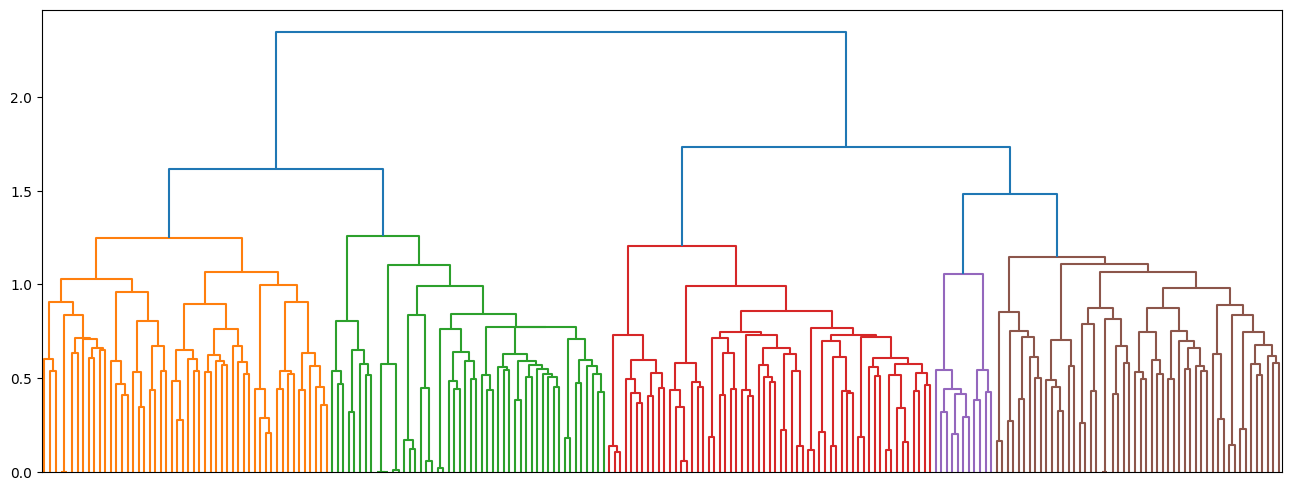

In [486]:
plt.figure(figsize=(16, 6))

_ = dendrogram(
    link,
    orientation='top',
    color_threshold=1.3,
    no_labels=True
)

plt.show()

<h3>Bootstrapping HClust</h3>

In [140]:
# same function as bootstrap_kmeans defined later
def bootstrap_hclust(n_clusters, n_samples=100):
    
    grouped_together = np.zeros((X.shape[0], X.shape[0]))
    counts = np.zeros((X.shape[0], X.shape[0]))
    
    for i in tqdm(range(n_samples)):
        indecies = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        Xb = X[indecies, :]
        
        link = linkage(Xb, 'ward', 'euclidean')
        assigned_groups = fcluster(link, n_clusters, criterion='maxclust')
        
        for i_num, i in enumerate(indecies):
            for j_num, j in enumerate(indecies[i_num:]):
                counts[i, j] += 1
                if assigned_groups[i_num] == assigned_groups[i_num + j_num]:
                    grouped_together[i, j] += 1    
            
    return np.divide(grouped_together, counts, out=np.zeros_like(grouped_together), where = counts!=0)

In [143]:
bootstrap_hclust_10 = bootstrap_hclust(n_clusters=3, n_samples=2500)

100%|███████████████████████████████████████| 2500/2500 [02:08<00:00, 19.41it/s]


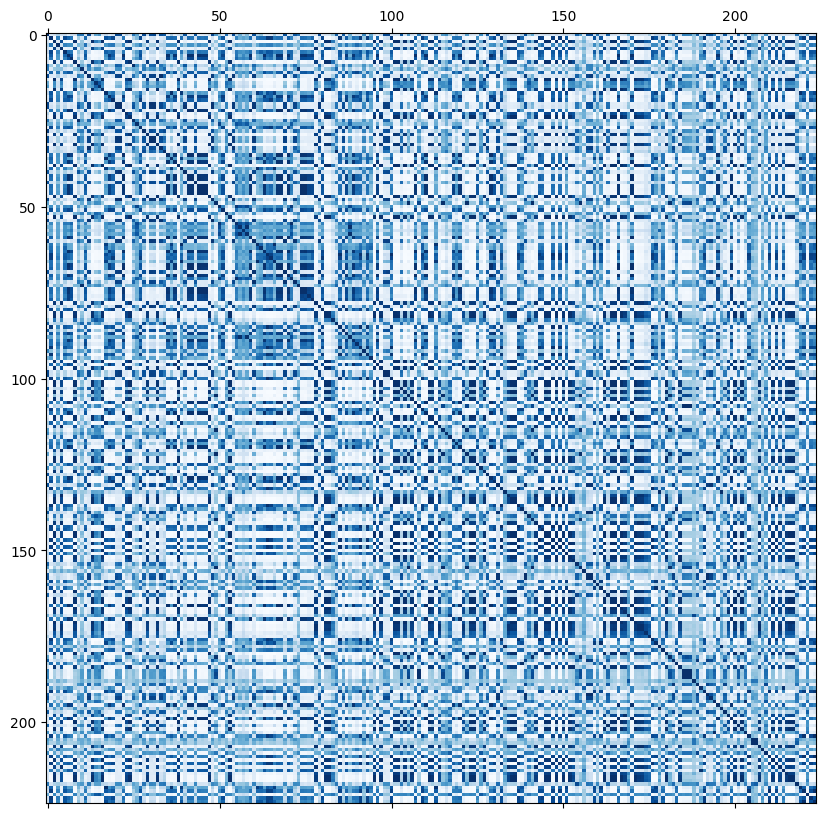

In [144]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.matshow(bootstrap_hclust_10, cmap=plt.cm.Blues)

<h3>PCA plot for embedded papers' keywords</h3>

In [487]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

In [488]:
pca = PCA(n_components=20).fit(X)
PCA_proj = pca.transform(X)

In [489]:
WSS, CH = [], []

for i in tqdm(range(2, 20)):
    kmeans = KMeans(
        n_clusters=i, n_init=50, max_iter=1000000, tol=1e-10
    ).fit(X)
    groups = kmeans.predict(X)
    calinski_score = calinski_harabasz_score(X, groups) # implementation from sklearn
    WSS.append(kmeans.inertia_)
    CH.append(calinski_score)

100%|███████████████████████████████████████████| 18/18 [00:17<00:00,  1.00it/s]


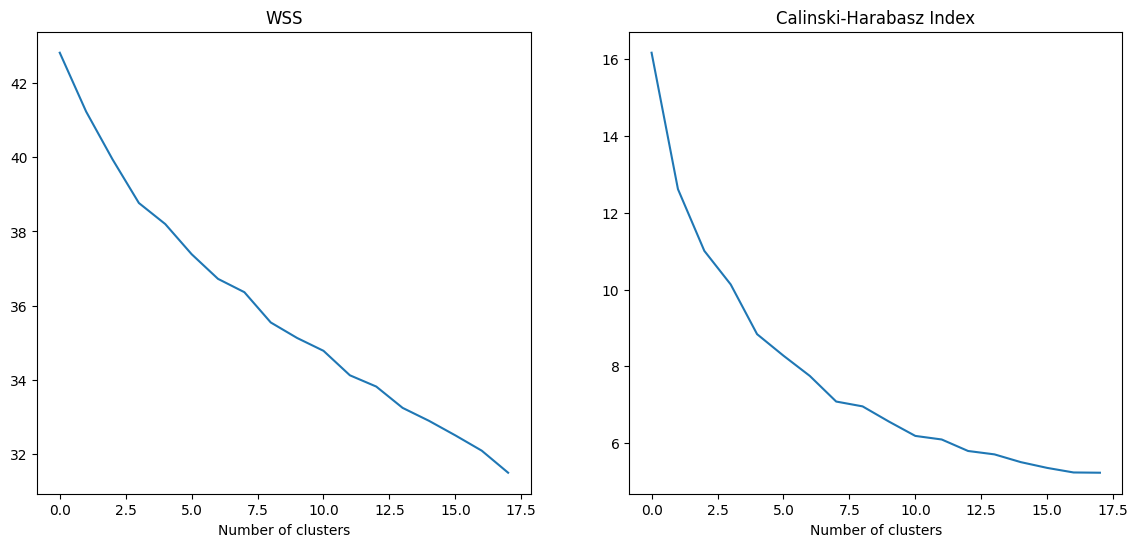

In [490]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)
ax1.plot(WSS)
ax1.set_title("WSS")
ax1.set_xlabel("Number of clusters")

ax2 = fig.add_subplot(122)
ax2.plot(CH)
ax2.set_title("Calinski-Harabasz Index")
ax2.set_xlabel("Number of clusters")

plt.show()

In [491]:
kmeans = KMeans(
    n_clusters=5, n_init=100, tol=1e-10
).fit(X)

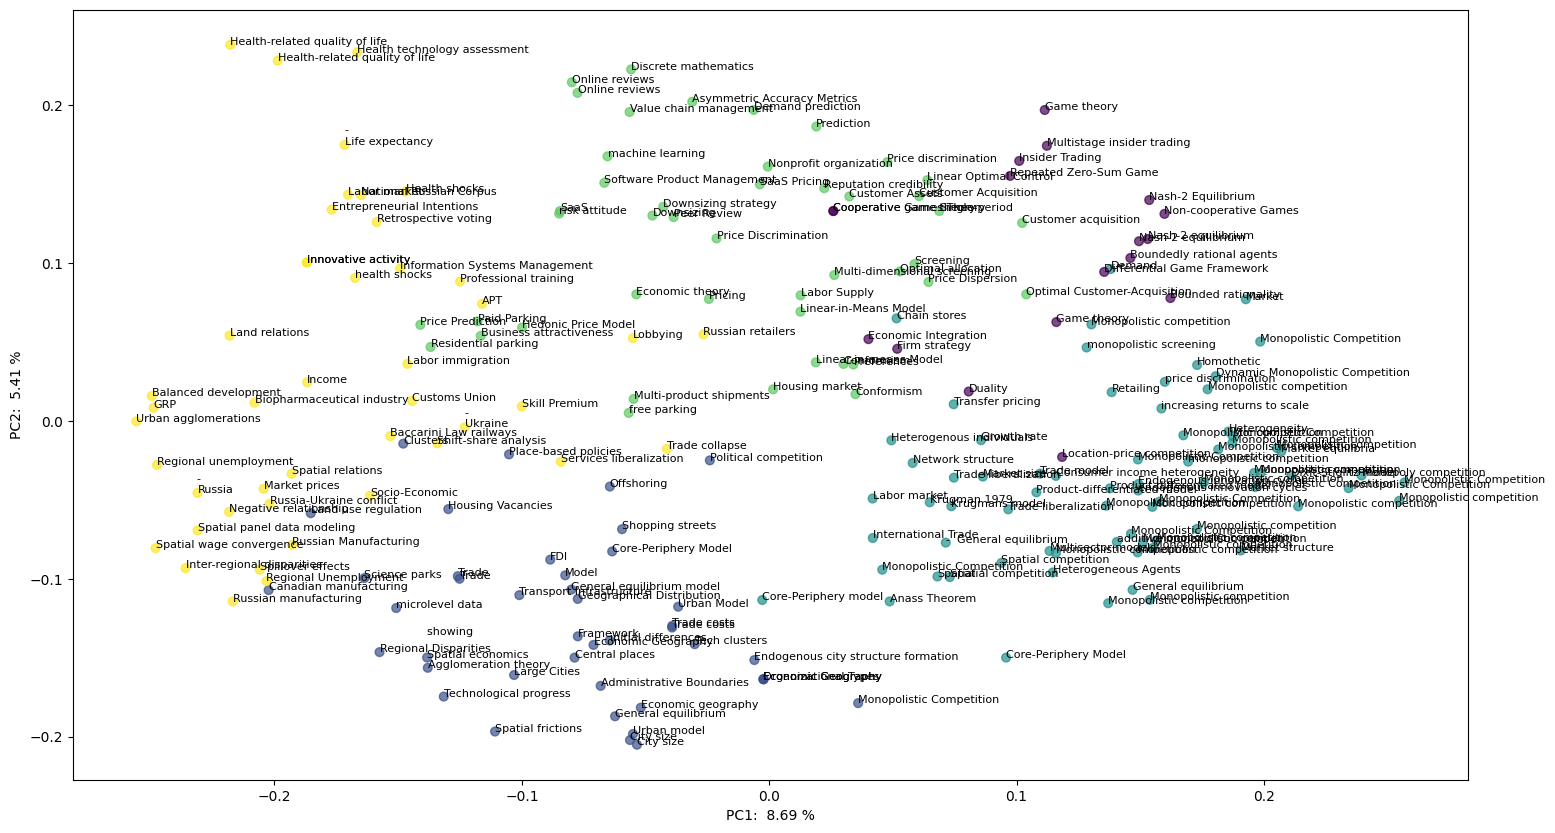

In [492]:
plt.figure(figsize=(18, 10))

plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], s=40, alpha=0.7, c=kmeans.labels_)
plt.xlabel("PC1:  {:.2f} %".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2:  {:.2f} %".format(pca.explained_variance_ratio_[1]*100))

for i, label in enumerate(df.keywords):
    plt.annotate(label[0], (PCA_proj[i, 0], PCA_proj[i, 1]), fontsize=8)

plt.savefig("lab.png", dpi=300, bbox_inches='tight')

In [493]:
df["kmeans_group"] = kmeans.labels_

In [575]:
df_pub_group = df.groupby("kmeans_group")["title"].count().to_frame()
df_pub_group.index = labels

df_pub_group.rename(columns={"title": "Количество публикаций"})

,Количество публикаций
Game Theory,18
Spatial Economics,43
Microeconomics,73
Business and Economics,45
Economics in other fields,45
